In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=add2509814da8234f98cd99f51cb51d386868f0010155c8e5ff04f3c75fb1bff
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf


# Importar datos

In [3]:
START_DATE = (datetime.now()-timedelta(50)).strftime('%Y-%m-%d')
END_DATE = datetime.now().strftime('%Y-%m-%d')
STOCK = 'AMZN'

def get_data(ticker):
  try:
    tickerData = yf.Ticker(STOCK)
    stock_data=tickerData.history(period='1d', start=START_DATE, end=END_DATE) 
  except RemoteDataError:
    print('No data found for {t}'.format(t=ticker))
  return stock_data


In [4]:
df=get_data(STOCK)
df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-08,3222.610107,3279.530029,3218.010010,3264.110107,3416700,0,0
2021-06-09,3272.870117,3297.580078,3270.699951,3281.149902,2455500,0,0
2021-06-10,3282.010010,3351.000000,3281.149902,3349.649902,3476500,0,0
2021-06-11,3349.649902,3366.580078,3333.449951,3346.830078,2817400,0,0
2021-06-14,3346.830078,3385.000000,3335.500000,3383.870117,2569700,0,0


# Transformaciòn de los datos y calculo indicadores


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.0,35.0
mean,3517.074295,3552.302016,3488.417704,3526.410840,3.454829e+06,0.0,0.0
std,143.197460,142.439197,130.900405,133.826441,1.074236e+06,0.0,0.0
min,3222.610107,3279.530029,3218.010010,3264.110107,2.037100e+06,0.0,0.0
25%,3425.305054,3456.515015,3405.209961,3436.564941,2.570650e+06,0.0,0.0
50%,3505.000000,3523.780029,3473.709961,3505.439941,3.277100e+06,0.0,0.0
75%,3641.780029,3690.439941,3603.534912,3647.334961,3.893450e+06,0.0,0.0
max,3744.000000,3773.080078,3696.790039,3731.409912,6.744800e+06,0.0,0.0


In [ ]:
def media_movil(num,df,column):
  df['media_{}_{}'.format(column,num)]=df[column].rolling(window=int(num),min_periods=1).mean()
  return df

In [ ]:
medias=['16','42']
for m in medias:
  df=media_movil(m,df,'Close')


In [ ]:
df['diff']=df.Close.diff(periods=1)
df.dropna(inplace=True)
df['sub']=df['diff'][df['diff']>0]
df['baj']=abs(df['diff'][df['diff']<=0])
df.fillna(value=0,inplace=True)
df['media_sub_14']=df['sub'].rolling(window=14).mean()
df['media_baj_14']=df['baj'].rolling(window=14).mean()
df['RSI']=100-(100/(1+(df.media_sub_14/df.media_baj_14)))
df.dropna(inplace=True)
df.drop(columns=['diff','sub','baj','media_sub_14','media_baj_14'],inplace=True)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,media_Close_16,media_Close_42,RSI
count,21.000000,21.000000,21.000000,21.000000,2.100000e+01,21.0,21.0,21.000000,21.000000,21.000000
mean,3578.729062,3613.618106,3545.274751,3582.610456,3.461862e+06,0.0,0.0,3508.489031,3441.566694,67.795488
std,111.463881,116.160408,106.087591,111.296071,1.187537e+06,0.0,0.0,82.356790,44.049779,4.884992
min,3416.000000,3448.000000,3394.179932,3401.459961,2.037100e+06,0.0,0.0,3381.110661,3381.110661,60.397027
25%,3464.000000,3511.719971,3435.000000,3449.080078,2.430700e+06,0.0,0.0,3433.361847,3394.163977,64.061487
50%,3576.379883,3640.020020,3543.639893,3585.199951,3.265400e+06,0.0,0.0,3524.319351,3448.693184,67.621337
75%,3694.199951,3717.659912,3622.040039,3677.360107,3.845900e+06,0.0,0.0,3577.010605,3483.324984,70.798822
max,3744.000000,3773.080078,3696.790039,3731.409912,6.744800e+06,0.0,0.0,3628.255615,3500.068555,77.003663


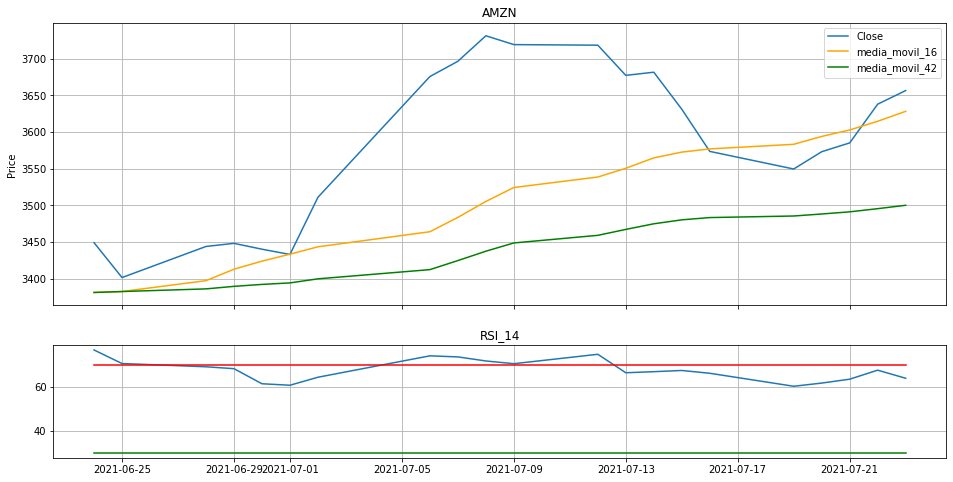

In [ ]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios': [2.5, 1]}, figsize=(16,8))


ax[0].plot(df.Close)
ax[0].plot(df.media_Close_16,'orange')
ax[0].plot(df.media_Close_42,'g')
ax[0].set_title(STOCK)
ax[0].set_ylabel('Price')
ax[0].legend(['Close','media_movil_16','media_movil_42'])
ax[0].grid(True)


ax[1].plot(df.RSI)
ax[1].plot(df.index,70*np.ones(df.shape[0]),'r')
ax[1].plot(df.index,30*np.ones(df.shape[0]),'g')
ax[1].set_title('RSI_14')
ax[1].grid(True)




plt.show()


# Implementaciòn Estrategia

In [ ]:
MR=df.media_Close_16.values[-2:]
ML=df.media_Close_42.values[-2:]
rsi=df.RSI[-1]
close=df.Close.values[-2:]

In [ ]:
def Crossover(MR,ML):
  if (MR[0]<ML[0] and MR[1]>=ML[1]):
    return True
  else:
    return False
def RSI_umbral(rsi):
  if rsi<30:
    return True
  else:
    return False

In [ ]:
print(Crossover(MR,ML))
print(RSI_umbral(rsi))
print(Crossover(MR,close))

False
False
False


In [ ]:
buy_sign_SMA=Crossover(MR,ML)
buy_sign_RSI=RSI_umbral(rsi)
sell_sign_SMA=Crossover(MR,close)


# Llamada a la API

In [ ]:
import requests, json
API_KEY='PKSV7UHBVU01KTP5GPY4'
SECRET_KEY='D12wf12S8oYnsOaI03ynQ8lfODzeZ87Q7wV1gBZR'
BASE_URL = "https://paper-api.alpaca.markets"
ACCOUNT_URL = "{}/v2/account".format(BASE_URL)
ORDERS_URL = "{}/v2/orders".format(BASE_URL)
OPEN_POSITION = "{}/v2/positions".format(BASE_URL)
HEADERS = {'APCA-API-KEY-ID': API_KEY, 'APCA-API-SECRET-KEY': SECRET_KEY}

def get_account():
    r = requests.get(ACCOUNT_URL, headers=HEADERS)

    return json.loads(r.content)


def create_order(symbol, qty, side, type, time_in_force):
    data = {
        "symbol": symbol,
        "qty": qty,
        "side": side,
        "type": type,
        "time_in_force": time_in_force
    }

    r = requests.post(ORDERS_URL, json=data, headers=HEADERS)

    return json.loads(r.content)

def get_orders():
    r = requests.get(ORDERS_URL, headers=HEADERS)

    return json.loads(r.content)

def get_cash():
  return float(get_account().get('cash'))
  
def get_open_positions():
  r = requests.get(OPEN_POSITION, headers=HEADERS)
  return json.loads(r.content)

def orden_pendiente(STOCK):
  #True si esperamos de completare un orden
  #else False
  for element in get_orders():
    if element.get('symbol') == STOCK:
    #print( element.get('status'))
      if element.get('status') == 'filled':
        print("La orden ha sido aceptada")
        return False
      else:
        return True
    else:
      return False

def position(STOCK):
  for element in  get_open_positions():
    if element.get('symbol') == STOCK:
      #print(element.get('qty'))
      return int(element.get('qty')) #numero posiziones abiertas en esta empresa
    else:
      return 0
  return 0

In [ ]:
buy_sign_SMA=True

In [ ]:
def Bot(STOCK):
  if orden_pendiente(STOCK):
    return 0
  if position(STOCK)>0:
    if sell_sign_SMA:
        create_order(STOCK, position(STOCK) , 'sell', 'market', 'gtc') #sell
  else:
    if (buy_sign_SMA or buy_sign_RSI):
      qty=int(get_cash()/close[-1])
      create_order(STOCK, qty, 'buy', 'market', 'gtc') #buy



In [ ]:
Bot('TSLA')

In [ ]:
print(position('AMZN'))

In [ ]:
get_open_positions()

[{'asset_class': 'us_equity',
  'asset_id': '8ccae427-5dd0-45b3-b5fe-7ba5e422c766',
  'avg_entry_price': '434.93',
  'change_today': '0.032970687443584',
  'cost_basis': '12612.97',
  'current_price': '434.86',
  'exchange': 'NASDAQ',
  'lastday_price': '420.98',
  'market_value': '12610.94',
  'qty': '29',
  'side': 'long',
  'symbol': 'TSLA',
  'unrealized_intraday_pl': '-2.03',
  'unrealized_intraday_plpc': '-0.000160945439496',
  'unrealized_pl': '-2.03',
  'unrealized_plpc': '-0.000160945439496'}]

In [ ]:
get_orders()

[{'asset_class': 'us_equity',
  'asset_id': '8ccae427-5dd0-45b3-b5fe-7ba5e422c766',
  'canceled_at': None,
  'client_order_id': 'de540799-b723-42cf-9355-51a7572d1a7a',
  'created_at': '2021-07-24T12:20:09.658646Z',
  'expired_at': None,
  'extended_hours': False,
  'failed_at': None,
  'filled_at': None,
  'filled_avg_price': None,
  'filled_qty': '0',
  'hwm': None,
  'id': 'b8a444d4-199b-4592-9d74-3001d7d5fc7b',
  'legs': None,
  'limit_price': None,
  'notional': None,
  'order_class': '',
  'order_type': 'market',
  'qty': '4',
  'replaced_at': None,
  'replaced_by': None,
  'replaces': None,
  'side': 'buy',
  'status': 'accepted',
  'stop_price': None,
  'submitted_at': '2021-07-24T12:20:09.64777Z',
  'symbol': 'TSLA',
  'time_in_force': 'gtc',
  'trail_percent': None,
  'trail_price': None,
  'type': 'market',
  'updated_at': '2021-07-24T12:20:09.658646Z'},
 {'asset_class': 'us_equity',
  'asset_id': 'f801f835-bfe6-4a9d-a6b1-ccbb84bfd75f',
  'canceled_at': None,
  'client_order_

In [ ]:
position(STOCK)

0

In [ ]:
def create_order_limit(symbol, qty, side, type, time_in_force,limit_price):
    data = {
        "symbol": symbol,
        "qty": qty,
        "side": side,
        "type": type,
        "time_in_force": time_in_force,
        "limit_price": limit_price

    }
    r = requests.post(ORDERS_URL, json=data, headers=HEADERS)

    return json.loads(r.content)

In [ ]:
response3 =create_order_limit("AMZN", 10, "buy", "limit", "gtc",180)